In [1]:
from pathlib import Path
import pandas as pd

In [2]:
DIR = Path(".")

RUNS = [
    DIR / "data-tuning" / "dampersweep",
    DIR / "data-tuning-ec2" / "dampersweep"
]

In [3]:
def cost(df):
    mu = df["model_updates"]
    loss = df["test_loss"]
    final_loss = df.iloc[-1]["test_loss"]
    return loss + mu/10_000

_dfs = {f.name: pd.read_pickle(f) for runs in RUNS for f in runs.glob("*.pkl.zip")}
print(f"Reading/trimming {len(_dfs)} training runs...")
# _dfs = {k: df for k, df in _dfs.items() if df.epochs.max() >= 99}
print(" "*4 + f"after trimming epochs=99: {len(_dfs)}")

dfs = []
for fname, df in _dfs.items():
    df["fname"] = fname
    df["cost"] = cost(df)

    dampers = list(df.damper.unique())
    assert len(dampers) == 1
    damper = dampers[0]
    if damper == "pradadamp":
        damper = "radadamp"
    damplr = (df.initial_batch_size == df.max_batch_size).all()
    if damplr:
        damper = f"{damper}lr"

    df["damper"] = damper
    dfs.append(df)

cols = [c for c in df.columns if c not in ["fname", "params", "epoch_time", "verbose", "no_cuda", "random_state", "init_seed", "dataset", "approx_loss", "test_freq"]]

df = pd.concat(dfs)
print(df.damper.value_counts())
df[cols].sample(n=5)

Reading/trimming 166 training runs...
    after trimming epochs=99: 166
damper
radadamplr    2626
padadamplr    2525
padadamp      2314
geodamp       1738
adagrad       1418
radadamp      1129
geodamplr      930
adamw          845
Name: count, dtype: int64


,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,lr,damper,rho,dwell,...,_epochs,_num_examples,_train_time,damping,_step_time,time,step_time,lr_,batch_size_,cost
55,16,8192,0.01,5,20,55.002815,0.000762,adagrad,0.990000,1.927323,...,1.0,58608.0,358.742471,16.0,0.102648,1.738230e+09,0.102930,0.000762,16.0,40.592773
72,32,32,0.01,5,20,72.023343,0.000104,radadamplr,0.778104,56.254546,...,1.0,58624.0,170.054628,147.0,0.079706,1.738222e+09,0.079849,0.000023,32.0,18.477041
73,128,128,0.01,5,20,73.023667,0.000373,radadamplr,0.532775,1.234422,...,1.0,58624.0,127.816942,253.0,0.254890,1.738219e+09,0.255088,0.000189,128.0,126.357085
83,256,4096,0.01,2,11,85.276546,0.002135,geodamp,0.990000,102.754853,...,1.0,61440.0,120.422544,32768.0,7.485574,1.738220e+09,7.498733,0.000267,4096.0,806.755062
21,32,32,0.01,2,10,21.006808,0.000072,geodamplr,0.990000,52.703622,...,1.0,58624.0,167.573632,128.0,0.090120,1.738241e+09,0.090346,0.000018,32.0,17.902456


In [4]:
import numpy as np

best_runs = []
print(df.damper.unique())
for damper in df.damper.unique():
    show = df[df.damper == damper]
    scores = show.pivot_table(
        values="cost",
        aggfunc="min",
        index="fname",
        columns="damper",
    )
    idx = scores[damper].argmin()
    best_row = scores.iloc[idx]
    assert np.allclose(best_row.item(), scores.min())
    fname = best_row.name
    best_runs.append(fname)
best_runs

['adamw' 'radadamplr' 'geodamp' 'padadamplr' 'padadamp' 'adagrad'
 'radadamp' 'geodamplr']


['dam=adamw-dam=20-dam=5-dwe=5.418607e+00-epo=100-gro=1.000000e-03-ini=64-lr=1.026317e-03-max=256-mom=9.949194e-01-nes=True-noi=False-red=mean-rho=9.900000e-01-wai=1.423280e+00-wei=3.628659e-02-201-0.pkl.zip',
 'dam=radadamplr-dam=20-dam=5-dwe=5.625455e+01-epo=100-gro=1.000000e-03-ini=32-lr=1.039919e-04-max=256-mom=8.538296e-01-nes=True-noi=False-red=mean-rho=7.781042e-01-wai=7.050016e+00-wei=1.945254e-06-201-1.pkl.zip',
 'dam=geodamp-dam=14-dam=3-dwe=3.684011e+02-epo=100-gro=1.000000e-03-ini=512-lr=3.387130e-04-max=8192-mom=9.255288e-01-nes=True-noi=False-red=mean-rho=9.900000e-01-wai=9.205661e+01-wei=1.044511e-06-201-0.pkl.zip',
 'dam=padadamplr-dam=20-dam=5-dwe=5.925865e+02-epo=100-gro=1.809587e-02-ini=64-lr=1.513523e-04-max=2048-mom=8.959041e-01-nes=True-noi=False-red=mean-rho=9.900000e-01-wai=4.786711e+01-wei=2.522148e-05-201-2.pkl.zip',
 'dam=padadamp-dam=20-dam=5-dwe=9.136266e+01-epo=100-gro=2.884216e-02-ini=128-lr=5.241874e-05-max=256-mom=9.275125e-01-nes=True-noi=False-red=mea

adamw [64]
radadamplr [32]
geodamp [512]
padadamplr [64]
padadamp [128]
adagrad [128]
radadamp [64]
geodamplr [32]


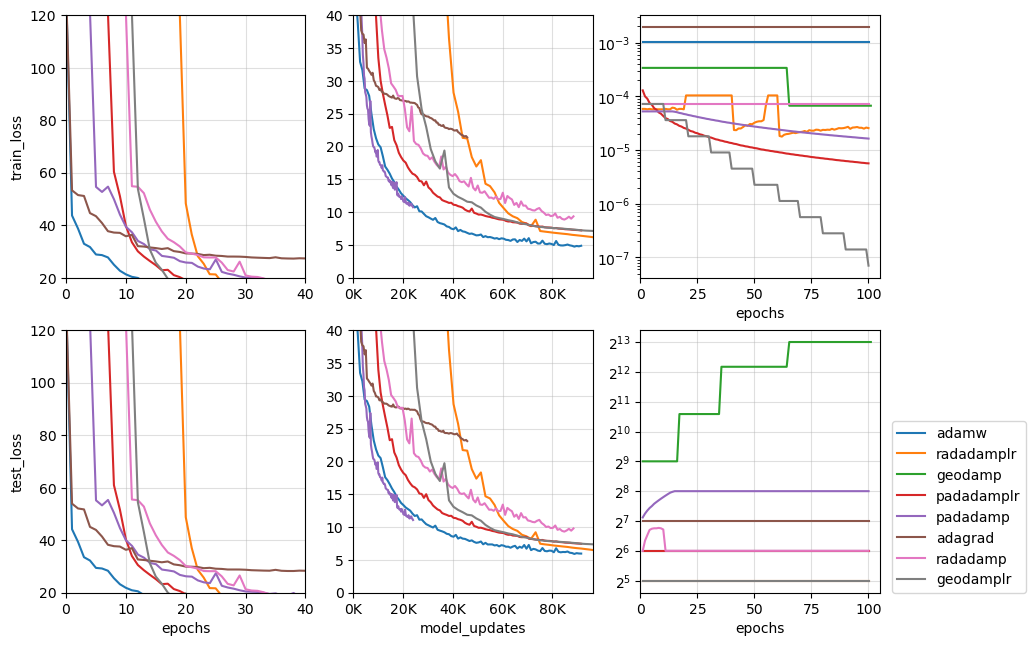

In [18]:
import matplotlib.pyplot as plt

def plot(show, damper, axs, debug=False):
    for i, loss in enumerate(["train_loss", "test_loss"]):
        for j, time in enumerate(["epochs", "model_updates"]):
            ax = show.plot(
                x=time,
                y=loss,
                ax=axs[i][j],
            )
            ax.set_ylabel(loss if j == 0 else "")
            ax.set_xlabel(time if i == 1 else "")
            if "updates" in time:
                ax.xaxis.set_major_formatter(lambda x, _: f"{int(x / 1e3)}K")

    for i, (time, damp) in enumerate([("epochs", "lr_"), ("epochs", "batch_size_")]):
        ax = show.plot(x=time, y=damp, ax=axs[i][2], label=damper)
        ax.set_yscale("log", base=2 if "batch" in damp else 10)
    
    for i, ax in enumerate(axs.flatten()):
        ax.grid(alpha=0.4)
        ax.set_xlim(0, None)
        if i in [0, 1, 3, 4]:
            ax.set_ylim(0, 40)
        if i != 5:
            ax.legend_.remove()
        else:
            ax.legend(loc=(1.05, 0))

        if debug:
            if i in [0, 3]:
                ax.set_xlim(0, 40)
                ax.set_ylim(20, 120)

w = 3
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(3.5 * w, 2.5 * w))
for run in best_runs:
    show = df[df.fname == run]
    assert len(show.fname.unique()) == 1
    damper = show.iloc[0]["damper"]
    print(damper, show.initial_batch_size.unique())
    plot(show, damper, axs, debug=True)




TODO:
 
* breaking condition: `if epochs >= 25 and 60 < train_loss`
* trim smaller search space.


* padadamp:
    * dwell: 1 to 300
    * growth rate: 1e-3 to 1e2
    * lr: 1e-5 to 0.5e-3
    * max_batch_size? 2^7 to 2^11
    * momentum: 0.6 to 0.95
    * wait: <= 30
    * weight_decay: 1e-7 to 1e-5
* padadamplr:
    * dwell: 1 to 1000 (10_000?)
    * growth_rate: (1e-3) 1e-2 to 5e-1
    * lr: 1e-5 to 2e-3
    * max_batch_size: >= 2^9 is good.
    * momentum: >0.55
    * wait: 1 to 100
    * weigth_decay: 3e-7 to 1e-4
* radadamp:
    * dwell: 1 to 1000
    * ibs: 2^4 best. 2^8 very good. smooth ramp.
    * lr: <= 3e-4
    * mbs: 2^11 best. 2^8 to 2^12 very good.
    * momentum: lower is better. all within 0.5 to 0.65.
    * wait: 3 to 100.
    * weight_decay: 1e-7 to 1e-4.
    * reduction: mean or min, doesn't really matter.
    * rho: 0.3 to 0.9
* radadamplr:
    * dwell: 20 to 1000
    * ibs: 2^4 to 2^5
    * lr: 1e-5 to 3e-4
    * mbs: 2^8 to 2^13
    * momentum: 0.6 to 0.9
    * wait: 1 to 100
    * weight_decay: 1e-6 to 1e-5
    * reduction: doesn't matter. mean slightly better.
    * rho: 0.7 to 0.8
* geodamp:
    * (nothing converged)
    * lr > 1e-3 diverged. lr<1e-4 will work?
* geodamplr (only one convereged):
    * lr=0.7e-4
    * dampingfactor=2, dampingdelay=10 
    * (change dwell to dwell=1)
* adagrad:
    * lr <= 4e-3
    * ibs looks god
    * weight_decay looks good
    * momentum looks good
* adamw
    * lr 1e-3 to 3e-3
    * ibs in [2^4, 2^6]
    * high momentum >= 0.98
    * weight-decay: 1e-3 to 1e-1

In [22]:
cv_results[cv_results.param_damper == "radadamp"].pivot_table(
    index="param_reduction",
    values="mean_test_score",
    aggfunc="max",
)

NameError: name 'cv_results' is not defined

In [104]:
show

,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,no_cuda,...,cost,opt_param_momentum,opt_param_dampening,opt_param_nesterov,norm2_hist,loss_hist,norm2,loss,opt_param_lr_decay,opt_param_initial_accumulator_value
0,1.738206e+09,64,256,0.01,5,20,0.000000,False,0.001026,False,...,131.854098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.738206e+09,64,256,0.01,5,20,1.000324,False,0.001026,False,...,44.132120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.738206e+09,64,256,0.01,5,20,2.000648,False,0.001026,False,...,39.320619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.738206e+09,64,256,0.01,5,20,3.000973,False,0.001026,False,...,33.474219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.738206e+09,64,256,0.01,5,20,4.001297,False,0.001026,False,...,32.215270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.738211e+09,64,256,0.01,5,20,96.031124,False,0.001026,False,...,6.026220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,1.738211e+09,64,256,0.01,5,20,97.031448,False,0.001026,False,...,5.887566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,1.738211e+09,64,256,0.01,5,20,98.031772,False,0.001026,False,...,6.007342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,1.738211e+09,64,256,0.01,5,20,99.032096,False,0.001026,False,...,5.955266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
